### Imports et initialisations

In [31]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import random
import re
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "only_hate_clusters/"
clean_dataset_file = "clean_dataset_hate"
raw_dataset_file = "dataset_hate"

##### Récupération des tweets

In [32]:
with open(clean_dataset_file, "r") as file:
    lines = file.readlines()
    
clean_sample = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_sample = file.readlines()

### Récupération des différents mots et de leur nombre d'occurences

Pour interpréter les résultats nous aurons besoin de connaître les mots les plus utilisés dans chaque cluster

Pour cela nous utilisons ces fonctions qui permettent d'obtenir une liste des mots du jeu de données (ou d'un sous ensemble comme ce sera le cas avec les clusters) triés par nombre d'occurences décroissant

In [7]:
#Création du dictionnaire de mots avec leur occurence
def create_wdict(lines):
    dico = {}
    for msg in lines:
        for mot in msg:
            if mot in dico: 
                dico[mot] += 1
            else:
                dico[mot] = 1
    return dico

#Création de la liste des mots triée par nombre d'occurences décroissant
def create_sorted_wlist(lines):
    dico = create_wdict(lines)
    wlist = [ (mot, dico[mot]) for mot in dico.keys()]
    return sorted(wlist, key = lambda mot: mot[1], reverse = True)

In [8]:
#dico = create_wdict(sample)

liste_mots_triee = create_sorted_wlist(clean_sample)

print("Il y a {} mots différents".format(len(liste_mots_triee)))
dict_len = len(liste_mots_triee) + 4
print("Les dix mots les plus utilisés sont :")
for mot in liste_mots_triee[1:10]:
    print(mot[0], end=' ')

Il y a 31702 mots différents
Les dix mots les plus utilisés sont :
français noir fils faire aller cest arabe pd pute 

### Encodage à l'aide d'un modèle word2vec entraîné avec les données

On charge le modèle depuis le disque

In [9]:
from gensim.models import KeyedVectors

In [10]:
w2v = KeyedVectors.load("w2vec_model_wordvectors")

In [11]:
#encode un message
def encode(msg):
    return np.mean([w2v[word] for word in msg if word in w2v] or [np.zeros(100)], axis = 0)

In [12]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg) for msg in clean_sample])

CPU times: user 433 ms, sys: 2.2 ms, total: 435 ms
Wall time: 434 ms


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode PCA

In [13]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 1.45 s, sys: 2.11 s, total: 3.56 s
Wall time: 477 ms


In [14]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["lines.markersize"] = 3

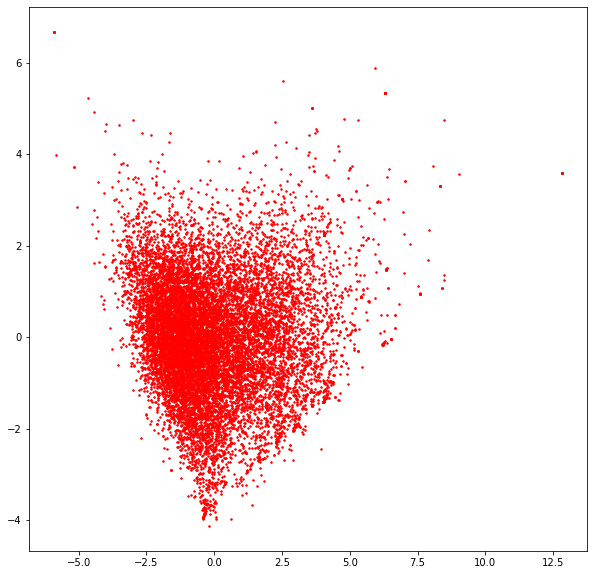

In [15]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

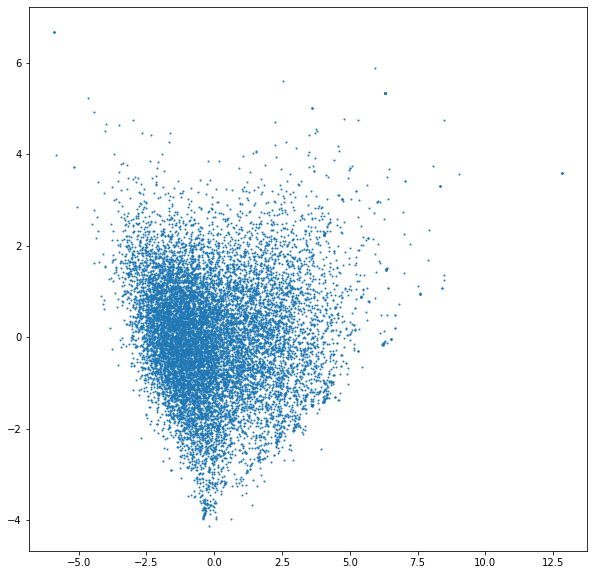

In [16]:
plt.scatter(b[0], b[1], s=1)
plt.show()

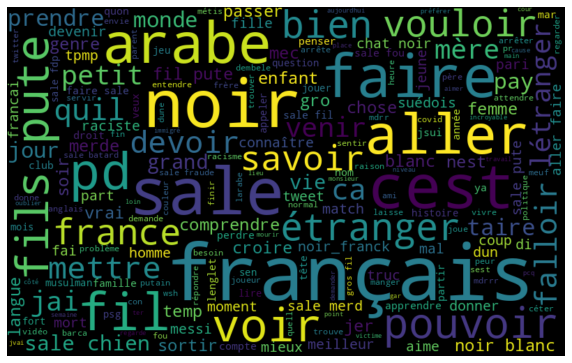

In [17]:
from wordcloud import WordCloud
all_words = ' '.join([" ".join(text) for text in clean_sample])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Fonctions pour la visualisation des clusters

Les algorithmes de classification renvoient une liste de la taille de notre dataset. Chaque élément de cette liste correspond au numéro de cluster auquel le message du même indice de notre jeu de données est associé.

Pour interpréter les résultats on a besoin de connaître les messages de chaque clusters on définit donc quelques fonctions qui vont nous permettre de manipuler les données :

- Une fonction qui construit un dictionnaire qui a chaque cluster associe la liste des indices des messages correspondants
- Une fonction qui construit la liste des mots et la liste des messages de chaque cluster.
- Une fonction qui affiche le nombre de messages pour chaque cluster
- Une fonction qui affiche pour chaque cluster la liste des n mots les plus utilisés
- Une fonction qui affiche un échantillon de messages pour chaque cluster
- Une fonction qui permet de visualiser les données catégorisées
- Et une fonction qui fait tout ça à la fois !

In [72]:
#Construire le dictionnaire des résultats qui à chaque cluster associe la liste indices des messages correspondants

def build_res_dict(pred):
    res = {}
    for i, lab in enumerate(pred): 
        if lab in res:
            res[lab].append(i)
        else:
            res[lab] = [i]
    return res
    
#construire la liste des mots et la liste des messages de chaque cluster
#utilise les variables globales clean_sample et raw_sample
def create_word_and_msg_lists(res):
    wlists = []
    mlists = []
    #parcourt les clés dans l'ordre croissant
    for i in sorted(res):
        idx_list = []
        msg_list = []
        raw_msg_list = []
        for n in res[i]: idx_list.append(n)
        for idx in idx_list: 
            msg_list.append(clean_sample[idx])
            raw_msg_list.append(raw_sample[idx])
        mlists.append(raw_msg_list)
        wlists.append(create_sorted_wlist(msg_list))
    return wlists, mlists

def print_clusters_info(n, res, wlists, centers):
    for i, key in enumerate(sorted(res)):
        print("cluster {} : {} messages".format(key, len(res[key])))
        print("Les {} mots les plus fréquents :".format(n), end=' ')
        for tup in wlists[i][:n]:
            print(tup[0], end=' ')
        print()
        print("Les mots les plus proches du centre :", end = ' ')
        for w in centers[i]:
            print(w, end=' ')
        print('\n')
        
def print_sample(sample_size, res):
    for i, key in enumerate(sorted(res)):
        print("cluster {} (clé {})".format(i, key))
        try:
            sample = random.sample(res[key], sample_size)
        except ValueError:
            sample = res[key]
        for j in sample:
            print(raw_sample[j])
        print()

def plot_results(res):
    styles = ["r.", "b.", "k.", "g.", "y.", "c.", "m."]
    i = 0
    j = 0
    for key in res.keys():
        cluster_data = []
        for idx in res[key]:
            cluster_data.append(two_dim_dataset[idx])
        tcd = np.array(cluster_data).T
        if (j > 6): j = 0
        plt.plot(tcd[0], tcd[1], styles[j])
        i += 1
        j += 1
    plt.show()
    
def save_clusters_msg(mlists, method):
    if not os.path.exists(cluster_dir): 
        os.mkdir(cluster_dir)
    if not os.path.exists(cluster_dir + method): 
        os.mkdir(cluster_dir + method)
    else :
        for file in os.scandir(cluster_dir + method):
            os.remove(file.path)
    for i, mlist in enumerate(mlists):
        with open(cluster_dir + "{0}/{0}_cluster_{1}_msg.txt".format(method, i), "w") as f:
            for msg in mlist:
                f.write(msg)
                
def parse_results(pred, method, centers):
    res = build_res_dict(pred)
    wlists, mlists = create_word_and_msg_lists(res)
    print_clusters_info(20, res, wlists, centers)
    #print_most_used_words(20, wlists)
    #print_sample(3, res)
    plot_results(res)
    save_clusters_msg(mlists, method)
    

### Kmeans

In [33]:
sum_of_squared_dist = []
for k in range(1, 30):
    km = KMeans(n_clusters=k)
    km.fit(dataset_encoded)
    sum_of_squared_dist.append(km.inertia_)

In [35]:
%%time
for k in range(30, 40):
    km = KMeans(n_clusters=k)
    km.fit(dataset_encoded)
    sum_of_squared_dist.append(km.inertia_)

In [38]:
%%time
for k in range(40, 50):
    km = KMeans(n_clusters=k)
    km.fit(dataset_encoded)
    sum_of_squared_dist.append(km.inertia_)

CPU times: user 6min 36s, sys: 1.44 s, total: 6min 37s
Wall time: 1min 37s


In [41]:
%%time
for k in range(50, 60):
    km = KMeans(n_clusters=k)
    km.fit(dataset_encoded)
    sum_of_squared_dist.append(km.inertia_)

CPU times: user 6min 30s, sys: 1.05 s, total: 6min 31s
Wall time: 1min 37s


<function matplotlib.pyplot.show(close=None, block=None)>

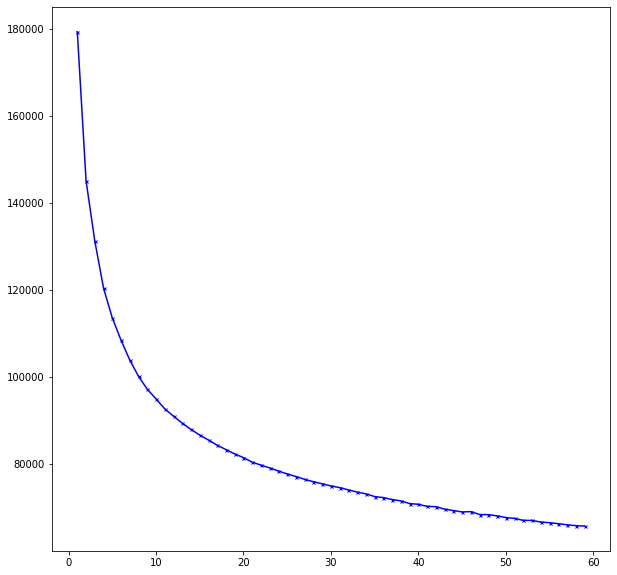

In [42]:
plt.plot(range(1, 60), sum_of_squared_dist, 'bx-')
plt.show

In [43]:
n_clust = 21

In [44]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(dataset_encoded)

CPU times: user 13.7 s, sys: 81.4 ms, total: 13.8 s
Wall time: 3.27 s


In [45]:
km_pred = kmeans.predict(dataset_encoded)

In [71]:
km_centers = c = [[r[0] for r in w2v.similar_by_vector(center)] for center in km_model.cluster_centers_]

In [111]:
w2v.similar_by_vector(w2v['salope'] - w2v['femme'] + w2v['homme'])

[('fdp', 0.598064124584198),
 ('salope', 0.5958377718925476),
 ('suntzufn', 0.5788425207138062),
 ('binks_ii', 0.5740616917610168),
 ('passement', 0.5734814405441284),
 ('qsg', 0.5732678174972534),
 ('nain', 0.571456789970398),
 ('bahahahahahah', 0.570777177810669),
 ('crasseux', 0.5695127844810486),
 ('valheim', 0.5693694949150085)]

cluster 0 : 1075 messages
Les 20 mots les plus fréquents : faire aller sale voir fils pd bien cest noir pouvoir savoir vouloir arabe mettre petit pute gros falloir devoir taire 
Les mots les plus proches du centre : pareil habituer galère inconnu parcequ imagine ect coté honnêtement sûrement 

cluster 1 : 1031 messages
Les 20 mots les plus fréquents : français faire étranger france pouvoir aller pays cest arabe vouloir devoir bien an voir falloir savoir létranger noir fils grand 
Les mots les plus proches du centre : exception décide visiblement malheureusement suppose permanence contrairement voire parvenir fonctionnaire 

cluster 2 : 254 messages
Les 20 mots les plus fréquents : sale pute chien fil lenglet pd fdp gros cest merd bts_twt gueule arabe fou enculer dembele bande messi con batard 
Les mots les plus proches du centre : sale sal band fdp pd enculer batard salope clochard tmr 

cluster 3 : 970 messages
Les 20 mots les plus fréquents : français étranger france faire an létrang

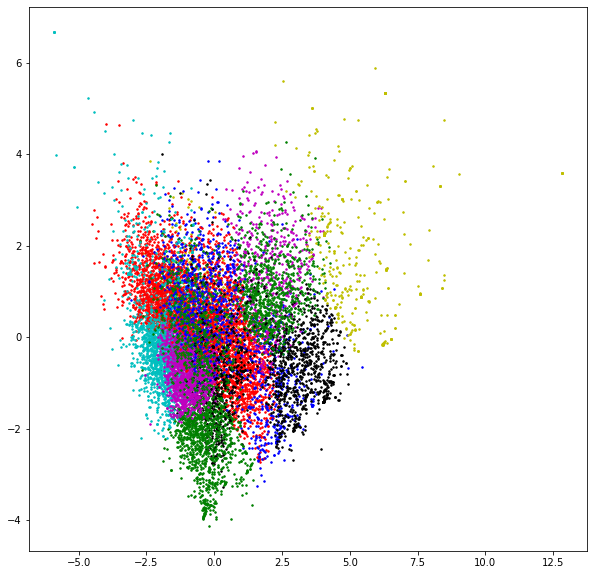

In [73]:
parse_results(km_pred, 'km', km_centers)

In [68]:
centers

array([[-0.18727617,  0.15365537,  0.10216495, ..., -0.56583846,
        -0.1149821 ,  0.4982676 ],
       [ 0.1141259 , -0.13380025,  0.26808912, ..., -0.33092487,
        -0.00418369,  0.48563677],
       [-0.18641262,  0.3649513 , -0.79125696, ..., -1.9001716 ,
         0.3670431 ,  0.94763845],
       ...,
       [ 0.16045816,  0.05043479, -0.11943731, ..., -1.010099  ,
         0.15377069,  0.14904621],
       [-0.17870662,  0.2857044 , -0.26697618, ..., -1.0755101 ,
         0.03606458,  0.75450027],
       [ 0.3280498 , -0.20332623,  0.03961039, ..., -2.073316  ,
        -0.8888226 , -0.2722988 ]], dtype=float32)

In [47]:
centers = km_model.cluster_centers_

In [48]:
c = [[r[0] for r in w2v.similar_by_vector(center)] for center in centers]
for i, res in enumerate(c):
    print("cluster {} : ".format(i), end='')
    for word in res:
        print(word, end = ' ')
    print()
        

cluster 0 : pareil habituer galère inconnu parcequ imagine ect coté honnêtement sûrement 
cluster 1 : exception décide visiblement malheureusement suppose permanence contrairement voire parvenir fonctionnaire 
cluster 2 : sale sal band fdp pd enculer batard salope clochard tmr 
cluster 3 : réserve exception parvenir permanence faillite entretenir destiner conserver idem prêts 
cluster 4 : sale sal band fdp pd ntm enculer tmr batard clochard 
cluster 5 : broyer noir blanche gris foncer blanc perruque barbe noire héron 
cluster 6 : grandmère salope mère chienne fils pute oncle gosse band bled 
cluster 7 : fameux suppose dison exception fréquenter généralement pensent persuader fameu coté 
cluster 8 : pd dembele sal daronn ntm fdp tmr degage ptit crasseux 
cluster 9 : comm dés icsi maudit passant aps parmis neter ducon grac 
cluster 10 : fils pute salope mère band clement_lenglet mere grandmère pvte fdp 
cluster 11 : français francai allemand italien étranger espagnol québécois létranger 

### SOM

In [49]:
from sklearn_som.som import SOM

In [50]:
som_normalized_dataset = np.array([vect / np.linalg.norm(vect) if np.linalg.norm(vect) != 0 else vect for vect in dataset_encoded])

In [51]:
%%time

som = SOM(m=4, n=5, dim=100)
som.fit(som_normalized_dataset)

CPU times: user 1.18 s, sys: 8.01 ms, total: 1.19 s
Wall time: 1.19 s


In [52]:
%%time

som_pred = som.predict(som_normalized_dataset)

CPU times: user 490 ms, sys: 0 ns, total: 490 ms
Wall time: 490 ms


In [115]:
som_centers = [[r[0] for r in w2v.similar_by_vector(center)] for center in som.weights]

cluster 0 : 613 messages
Les 20 mots les plus fréquents : fils pute mère lenglet fil chien cest gros bande père aller grand pvte dembele mort putain petit dieu appeler lhomme 
Les mots les plus proches du centre : grandmère ordure humilier oncle bellemère prostituer bled flic gosse chienne 

cluster 1 : 508 messages
Les 20 mots les plus fréquents : fils mère an faire cest fille père famille voir enfant dieu aller pute femme petit mort vie maman vouloir jour 
Les mots les plus proches du centre : ordure occupe humilier fréquenter diable humiliation halluciner abandonne écœurer méritent 

cluster 2 : 608 messages
Les 20 mots les plus fréquents : fils an faire noir étranger pouvoir aller voir venir enfant jour partir paris bien fil létranger vie famille vouloir soir 
Les mots les plus proches du centre : exception absent fréquenter répétition réserve fameux écarter dison prêts suppose 

cluster 3 : 842 messages
Les 20 mots les plus fréquents : étranger faire france létranger pouvoir franç

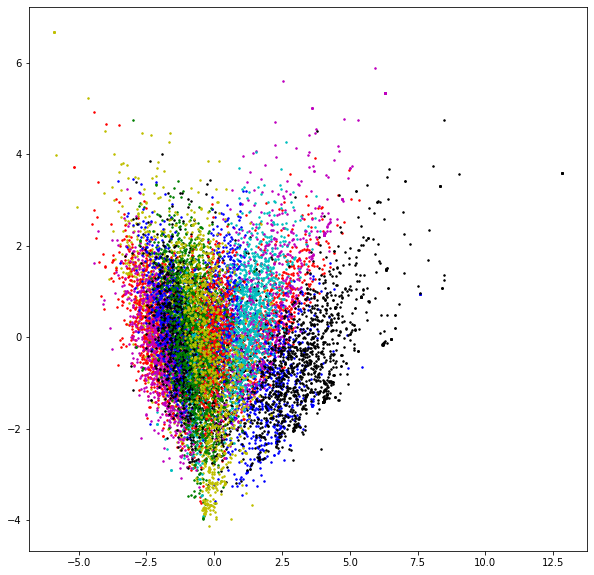

In [116]:
parse_results(som_pred, "som", som_centers)

### DBSCAN

In [97]:
from sklearn.cluster import DBSCAN

In [98]:
%%time

dbscan_pred = DBSCAN().fit_predict(dataset_encoded)

CPU times: user 19min 7s, sys: 19.3 s, total: 19min 26s
Wall time: 19min 29s


cluster 0 : 4810 messages
cluster 1 : 7 messages
cluster 2 : 5 messages
cluster 3 : 8 messages
cluster 4 : 6 messages
cluster 5 : 6 messages
cluster 6 : 5 messages
cluster 7 : 5 messages
cluster 8 : 35 messages
cluster 9 : 7 messages
cluster 10 : 9 messages
cluster 11 : 6 messages
cluster 12 : 5 messages
cluster 13 : 18 messages
cluster 14 : 5 messages
cluster 15 : 5 messages
cluster 16 : 6 messages
cluster 17 : 6 messages
cluster 18 : 5 messages
cluster 19 : 5 messages
cluster 20 : 5 messages
cluster 21 : 6 messages
cluster 22 : 7 messages
cluster 23 : 10 messages
cluster 24 : 8 messages
Les 20 mots les plus fréquents du cluster 0 : a ça plus si quand fait faire tout cette être comme bien va trop tous quoi non là rt rien 

Les 20 mots les plus fréquents du cluster 1 : oui 

Les 20 mots les plus fréquents du cluster 2 : voilà 

Les 20 mots les plus fréquents du cluster 3 : merci 

Les 20 mots les plus fréquents du cluster 4 : yassification 

Les 20 mots les plus fréquents du cluster 5 

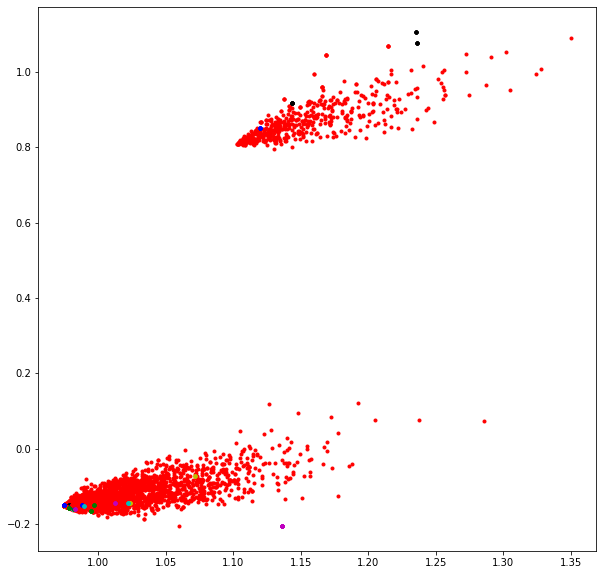

In [151]:
parse_results(dbscan_pred, "dbscan")

In [155]:
from sklearn.metrics import pairwise_distances

a = dataset_encoded[0]
b = dataset_encoded[1]

pairwise_distances(dataset_encoded)

array([[0.        , 5.38516481, 3.46410162, ..., 4.79583152, 3.87298335,
        3.60555128],
       [5.38516481, 0.        , 5.56776436, ..., 6.4807407 , 6.        ,
        5.83095189],
       [3.46410162, 5.56776436, 0.        , ..., 5.        , 4.35889894,
        4.12310563],
       ...,
       [4.79583152, 6.4807407 , 5.        , ..., 0.        , 5.47722558,
        5.29150262],
       [3.87298335, 6.        , 4.35889894, ..., 5.47722558, 0.        ,
        4.47213595],
       [3.60555128, 5.83095189, 4.12310563, ..., 5.29150262, 4.47213595,
        0.        ]])

### Affinity propagation

In [156]:
from sklearn.cluster import AffinityPropagation

In [157]:
%%time

AP_pred = AffinityPropagation().fit_predict(dataset_encoded)

CPU times: user 5min 8s, sys: 987 ms, total: 5min 9s
Wall time: 5min 9s


/home/victor/fidle/fidle-env/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


cluster 0 : 5000 messages
Les 20 mots les plus fréquents du cluster 0 : a ça plus si quand tout faire fait cette être comme bien va trop non tous quoi merci rt là 

cluster 0 (clé -1)
M. Pokora si les actes ne l’avait pas manqués https://t.co/Q7U9upiEjc

Le programme des équipes du CBB jouant à domicile samedi prochain #cherbourgbasketball #cherbourg #basket #CBB #championnat #matchs #region https://t.co/44W849jlGG

C'est une de nos qualités quand on est Army😌😌 tmtc




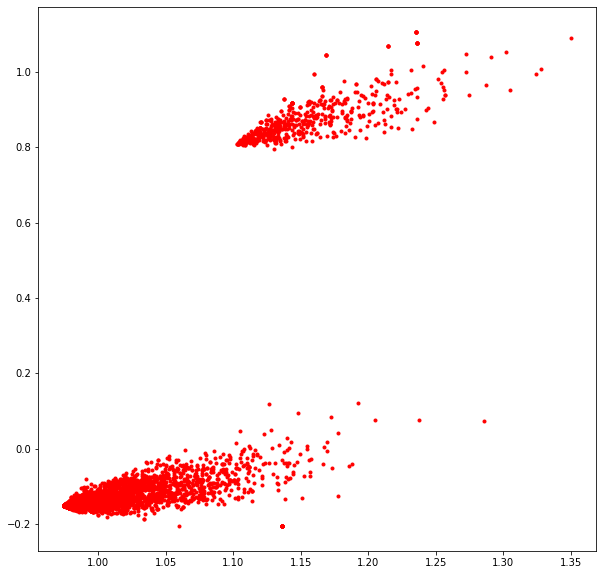

In [159]:
parse_results(AP_pred, "AP")